Folder CNH_Frente: found 3600, processing 200


Tampering CNH_Frente: 100%|██████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 40.04it/s]


Folder CPF_Frente: found 3600, processing 200


Tampering CPF_Frente: 100%|██████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 43.69it/s]


Folder RG_Verso: found 3600, processing 200


Tampering RG_Verso: 100%|████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 35.72it/s]


Folder RG_Aberto: found 3600, processing 200


Tampering RG_Aberto: 100%|███████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.07it/s]


Folder CNH_Aberta: found 3601, processing 200


Tampering CNH_Aberta: 100%|██████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.59it/s]



=== Summary ===
CNH_Frente: found 3600, tampered 200
CPF_Frente: found 3600, tampered 200
RG_Verso: found 3600, tampered 200
RG_Aberto: found 3600, tampered 200
CNH_Aberta: found 3601, tampered 200
TOTAL tampered: 1000
Tampered dataset root: C:\Users\mujta\.cache\kagglehub\datasets\syedmisbah\brazilian-id-dataset\versions\1\BID Dataset\tampered_dataset


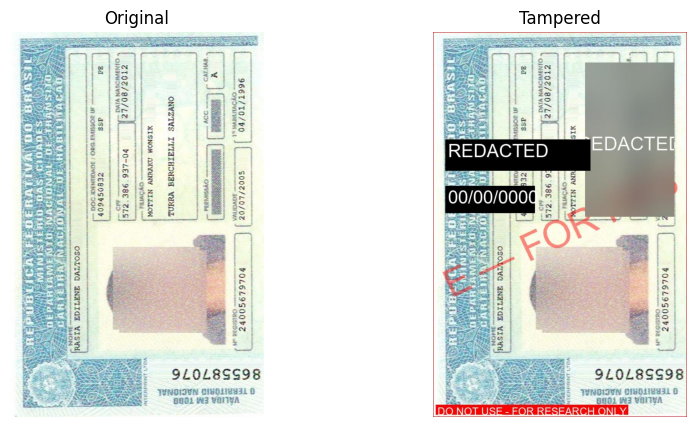

In [4]:
# Tamper 200 images per folder safely (visibly marked) across multiple folders.
# Run in Jupyter. Requirements: pillow, tqdm, matplotlib (optional preview)
# pip install pillow tqdm matplotlib

import os, random
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------- EDIT THESE ----------
dataset_path = r"C:\Users\mujta\.cache\kagglehub\datasets\syedmisbah\brazilian-id-dataset\versions\1\BID Dataset"
target_folders = ["CNH_Frente", "CPF_Frente", "RG_Verso", "RG_Aberto", "CNH_Aberta"]
PER_FOLDER = 200                 # number of images to tamper per folder
out_root = os.path.join(dataset_path, "tampered_dataset")
preview_one_example = True       # set False to skip preview at end

# ---------- helper functions ----------
def find_images_in_folder(folder):
    # Prefer *_in.jpg files, fallback to any jpg/jpeg/png
    files = [f for f in os.listdir(folder) if f.lower().endswith("_in.jpg")]
    if not files:
        files = [f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    return [os.path.join(folder, f) for f in files]

def get_font(size):
    try:
        return ImageFont.truetype("arial.ttf", size)
    except Exception:
        return ImageFont.load_default()

def safe_tamper_image(src_path, dst_path):
    """
    Safe non-realistic tampering:
      - diagonal SAMPLE watermark
      - blur & 'REDACTED' over an estimated photo-area
      - redact name/expiry boxes with REPLACED/00/00/0000 (relative)
      - red border + DO NOT USE tag
    """
    try:
        orig = Image.open(src_path).convert("RGB")
    except Exception as e:
        return False, f"load_error: {e}"
    w, h = orig.size
    tampered = orig.copy()

    # 1) watermark
    font = get_font(int(max(w, h) / 10))
    text = "SAMPLE — FOR RESEARCH"
    txt_img = Image.new("RGBA", tampered.size, (255,255,255,0))
    txt_draw = ImageDraw.Draw(txt_img)
    bbox = txt_draw.textbbox((0,0), text, font=font)
    text_w, text_h = bbox[2]-bbox[0], bbox[3]-bbox[1]
    x_center = (w - text_w) // 2
    y_center = (h - text_h) // 2
    txt_draw.text((x_center, y_center), text, font=font, fill=(255,0,0,120))
    txt_img = txt_img.rotate(25, expand=0)
    tampered = Image.alpha_composite(tampered.convert("RGBA"), txt_img).convert("RGB")

    # 2) estimated photo box (relative) -> blur and write REDACTED
    photo_box = (int(w * 0.60), int(h * 0.08), int(w * 0.95), int(h * 0.48))
    try:
        photo_region = tampered.crop(photo_box)
        blurred = photo_region.filter(ImageFilter.GaussianBlur(radius=25))
        bd = Image.new("RGBA", blurred.size)
        bd_draw = ImageDraw.Draw(bd)
        small_font = get_font(max(12, int(blurred.size[1] / 8)))
        txt = "REDACTED"
        bbox = bd_draw.textbbox((0,0), txt, font=small_font)
        tw, th = bbox[2]-bbox[0], bbox[3]-bbox[1]
        bd_draw.rectangle([(0,0), blurred.size], fill=(0,0,0,90))
        bd_draw.text(((blurred.size[0]-tw)//2, (blurred.size[1]-th)//2), txt, font=small_font, fill=(255,255,255,220))
        blurred = Image.alpha_composite(blurred.convert("RGBA"), bd).convert("RGB")
        tampered.paste(blurred, photo_box)
    except Exception:
        pass

    # 3) estimated name & expiry boxes -> draw opaque rect and text
    name_box = (int(w*0.05), int(h*0.28), int(w*0.62), int(h*0.36))
    expiry_box = (int(w*0.05), int(h*0.40), int(w*0.40), int(h*0.47))
    d = ImageDraw.Draw(tampered)
    try:
        d.rectangle(name_box, fill=(0,0,0,170))
        d.rectangle(expiry_box, fill=(0,0,0,170))
        label_font = get_font(max(12, int((name_box[3]-name_box[1])*0.6)))
        d.text((name_box[0]+6, name_box[1]+2), "REDACTED", fill=(255,255,255), font=label_font)
        d.text((expiry_box[0]+6, expiry_box[1]+2), "00/00/0000", fill=(255,255,255), font=label_font)
    except Exception:
        pass

    # 4) border + small footer tag
    border_draw = ImageDraw.Draw(tampered)
    try:
        border_draw.rectangle([0,0,w-1,h-1], outline=(255,0,0))
        foot_font = get_font(max(10, int(h*0.028)))
        foot_text = "DO NOT USE - FOR RESEARCH ONLY"
        bbox = border_draw.textbbox((0,0), foot_text, font=foot_font)
        tw, th = bbox[2]-bbox[0], bbox[3]-bbox[1]
        border_draw.rectangle([6, h-6-th-4, 12+tw, h-6], fill=(255,0,0,200))
        border_draw.text((10, h-6-th-2), foot_text, fill=(255,255,255), font=foot_font)
    except Exception:
        pass

    # Save
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    try:
        tampered.save(dst_path)
    except Exception as e:
        return False, f"save_error: {e}"
    return True, "ok"

# ---------- process each folder ----------
summary = {}
total_processed = 0
errors = []

for fld in target_folders:
    class_folder = os.path.join(dataset_path, fld)
    if not os.path.isdir(class_folder):
        print(f"Warning: folder not found (skipping): {class_folder}")
        summary[fld] = {"found":0, "processed":0}
        continue

    imgs = find_images_in_folder(class_folder)
    n_found = len(imgs)
    n_to_take = min(PER_FOLDER, n_found)
    if n_found == 0:
        summary[fld] = {"found":0, "processed":0}
        print(f"No images found in {fld}, skipping.")
        continue

    sampled = imgs if n_to_take == n_found else random.sample(imgs, n_to_take)
    print(f"Folder {fld}: found {n_found}, processing {len(sampled)}")
    processed = 0
    for src_path in tqdm(sampled, desc=f"Tampering {fld}", leave=True):
        basename = os.path.basename(src_path)
        out_dir = os.path.join(out_root, fld)
        out_path = os.path.join(out_dir, "tampered_" + basename)
        ok, msg = safe_tamper_image(src_path, out_path)
        if not ok:
            errors.append((src_path, msg))
        else:
            processed += 1
            total_processed += 1
    summary[fld] = {"found": n_found, "processed": processed}

# ---------- final summary ----------
print("\n=== Summary ===")
for fld, info in summary.items():
    print(f"{fld}: found {info['found']}, tampered {info['processed']}")
print(f"TOTAL tampered: {total_processed}")
if errors:
    print(f"Errors: {len(errors)} (showing up to 5):")
    for e in errors[:5]:
        print(" -", e[0], "->", e[1])

print("Tampered dataset root:", out_root)

# ---------- optional preview of one random tampered image ----------
if preview_one_example:
    # pick any tampered image and show original vs tampered if original exists
    any_tampered = None
    for fld in target_folders:
        d = os.path.join(out_root, fld)
        if os.path.isdir(d):
            files = [f for f in os.listdir(d) if f.lower().startswith("tampered_") and f.lower().endswith((".jpg",".jpeg",".png"))]
            if files:
                any_tampered = os.path.join(d, files[0])
                orig_candidate = os.path.join(dataset_path, fld, files[0].replace("tampered_",""))
                break

    if any_tampered:
        tam = Image.open(any_tampered).convert("RGB")
        plt.figure(figsize=(10,5))
        if os.path.exists(orig_candidate):
            org = Image.open(orig_candidate).convert("RGB")
            plt.subplot(1,2,1); plt.imshow(org); plt.title("Original"); plt.axis("off")
            plt.subplot(1,2,2); plt.imshow(tam); plt.title("Tampered"); plt.axis("off")
        else:
            plt.imshow(tam); plt.title("Tampered"); plt.axis("off")
        plt.show()
    else:
        print("No tampered images found for preview.")
